# Polynomial Regression vs ElasticNet: 3D Visualization

This notebook compares polynomial regression and ElasticNet regularization using 2D input data with 3D prediction surfaces.

## Learning Objectives:
- Compare polynomial regression with ElasticNet regularization
- Visualize prediction surfaces in 3D
- Understand overfitting vs. regularization trade-offs
- See how different methods handle complex patterns


In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("3D visualization capabilities ready!")


Libraries imported successfully!
3D visualization capabilities ready!


Dataset created:
- Samples: 200
- Features: 2D (X1, X2)
- True function: y = 0.5*X1² + 0.3*X2² + 0.2*X1*X2 + 0.1*X1 + 0.1*X2
- Added 20 outliers
\nData split:
- Training samples: 140
- Test samples: 60


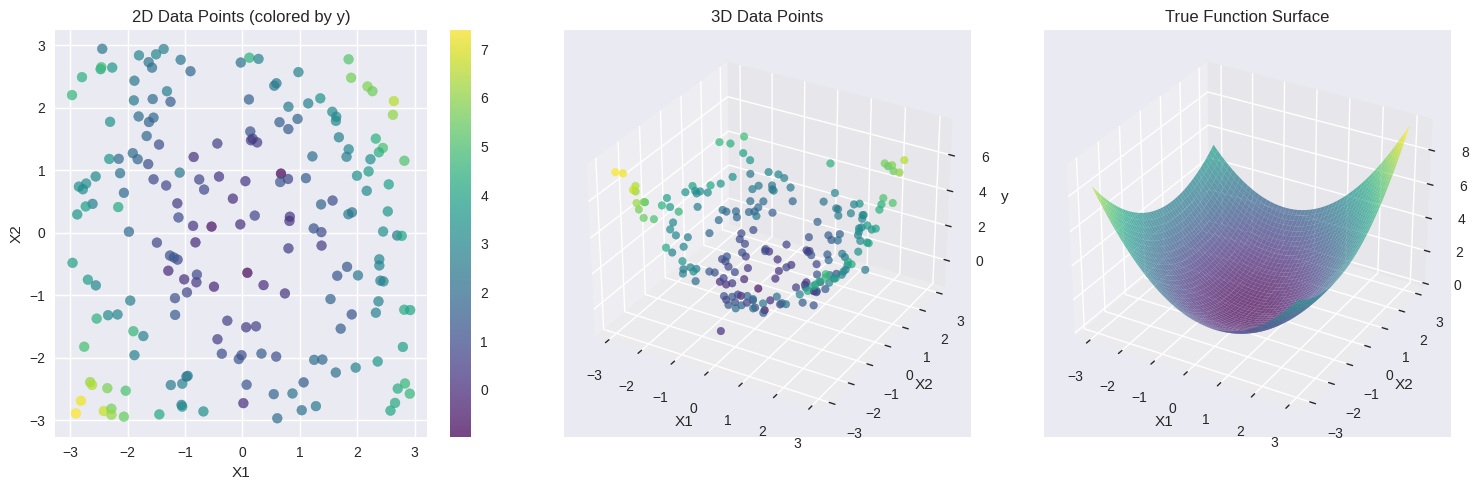

In [2]:
# Generate 2D dataset with complex patterns
np.random.seed(42)

# Create 2D input data
n_samples = 200
X1 = np.random.uniform(-3, 3, n_samples)
X2 = np.random.uniform(-3, 3, n_samples)
X = np.column_stack([X1, X2])

# Create complex target function with multiple patterns
# True function: y = 0.5*X1² + 0.3*X2² + 0.2*X1*X2 + 0.1*X1 + 0.1*X2 + noise
y_true = (0.5 * X1**2 + 
          0.3 * X2**2 + 
          0.2 * X1 * X2 + 
          0.1 * X1 + 
          0.1 * X2)

# Add noise
noise = np.random.normal(0, 0.3, n_samples)
y = y_true + noise

# Add some outliers
outlier_indices = np.random.choice(n_samples, size=20, replace=False)
y[outlier_indices] += np.random.normal(0, 1.5, len(outlier_indices))

print(f"Dataset created:")
print(f"- Samples: {n_samples}")
print(f"- Features: 2D (X1, X2)")
print(f"- True function: y = 0.5*X1² + 0.3*X2² + 0.2*X1*X2 + 0.1*X1 + 0.1*X2")
print(f"- Added {len(outlier_indices)} outliers")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\\nData split:")
print(f"- Training samples: {X_train.shape[0]}")
print(f"- Test samples: {X_test.shape[0]}")

# Visualize the data
fig = plt.figure(figsize=(15, 5))

# 2D scatter plot
ax1 = fig.add_subplot(131)
scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, s=50)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('2D Data Points (colored by y)')
plt.colorbar(scatter, ax=ax1)

# 3D scatter plot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X[:, 0], X[:, 1], y, c=y, cmap='viridis', alpha=0.7, s=30)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('y')
ax2.set_title('3D Data Points')

# True surface (for reference)
ax3 = fig.add_subplot(133, projection='3d')
X1_surf = np.linspace(-3, 3, 50)
X2_surf = np.linspace(-3, 3, 50)
X1_grid, X2_grid = np.meshgrid(X1_surf, X2_surf)
y_surf = (0.5 * X1_grid**2 + 
          0.3 * X2_grid**2 + 
          0.2 * X1_grid * X2_grid + 
          0.1 * X1_grid + 
          0.1 * X2_grid)

surf = ax3.plot_surface(X1_grid, X2_grid, y_surf, alpha=0.7, cmap='viridis')
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')
ax3.set_zlabel('y')
ax3.set_title('True Function Surface')

plt.tight_layout()
plt.show()


In [3]:
# Create models for comparison
def create_models():
    """
    Create polynomial and ElasticNet models with different complexities
    """
    models = {}
    
    # Polynomial regression models with different degrees
    for degree in [1, 2, 3, 4, 5]:
        poly_model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=True)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
        models[f'Polynomial_Degree_{degree}'] = poly_model
    
    # ElasticNet models with different regularization strengths
    alphas = [0.01, 0.1, 1.0, 10.0]
    for alpha in alphas:
        # Use degree 3 polynomial features with ElasticNet
        elastic_model = Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=True)),
            ('scaler', StandardScaler()),
            ('regressor', ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=2000))
        ])
        models[f'ElasticNet_α{alpha}'] = elastic_model
    
    return models

# Create and fit all models
print("Creating and fitting models...")
models = create_models()
fitted_models = {}
results = {}

for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    fitted_models[name] = model
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results[name] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_features': model.named_steps['poly'].n_output_features_ if 'poly' in model.named_steps else 2
    }
    
    print(f"✓ {name}: Train R² = {train_r2:.3f}, Test R² = {test_r2:.3f}")

print("\\nAll models fitted successfully!")

# Display results table
print("\\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(f"{'Model':<20} {'Train R²':<10} {'Test R²':<10} {'Train MSE':<12} {'Test MSE':<12} {'Features':<10}")
print("-"*80)

for name, result in results.items():
    print(f"{name:<20} {result['train_r2']:<10.3f} {result['test_r2']:<10.3f} "
          f"{result['train_mse']:<12.3f} {result['test_mse']:<12.3f} {result['n_features']:<10}")

print("="*80)


Creating and fitting models...
✓ Polynomial_Degree_1: Train R² = 0.006, Test R² = -0.001
✓ Polynomial_Degree_2: Train R² = 0.926, Test R² = 0.886
✓ Polynomial_Degree_3: Train R² = 0.928, Test R² = 0.881
✓ Polynomial_Degree_4: Train R² = 0.934, Test R² = 0.879
✓ Polynomial_Degree_5: Train R² = 0.940, Test R² = 0.866
✓ ElasticNet_α0.01: Train R² = 0.927, Test R² = 0.882
✓ ElasticNet_α0.1: Train R² = 0.913, Test R² = 0.879
✓ ElasticNet_α1.0: Train R² = 0.500, Test R² = 0.501
✓ ElasticNet_α10.0: Train R² = 0.000, Test R² = -0.008
\nAll models fitted successfully!
\n================================================================================
MODEL COMPARISON RESULTS
Model                Train R²   Test R²    Train MSE    Test MSE     Features  
--------------------------------------------------------------------------------
Polynomial_Degree_1  0.006      -0.001     2.978        2.105        3         
Polynomial_Degree_2  0.926      0.886      0.223        0.240        6         
Polyn

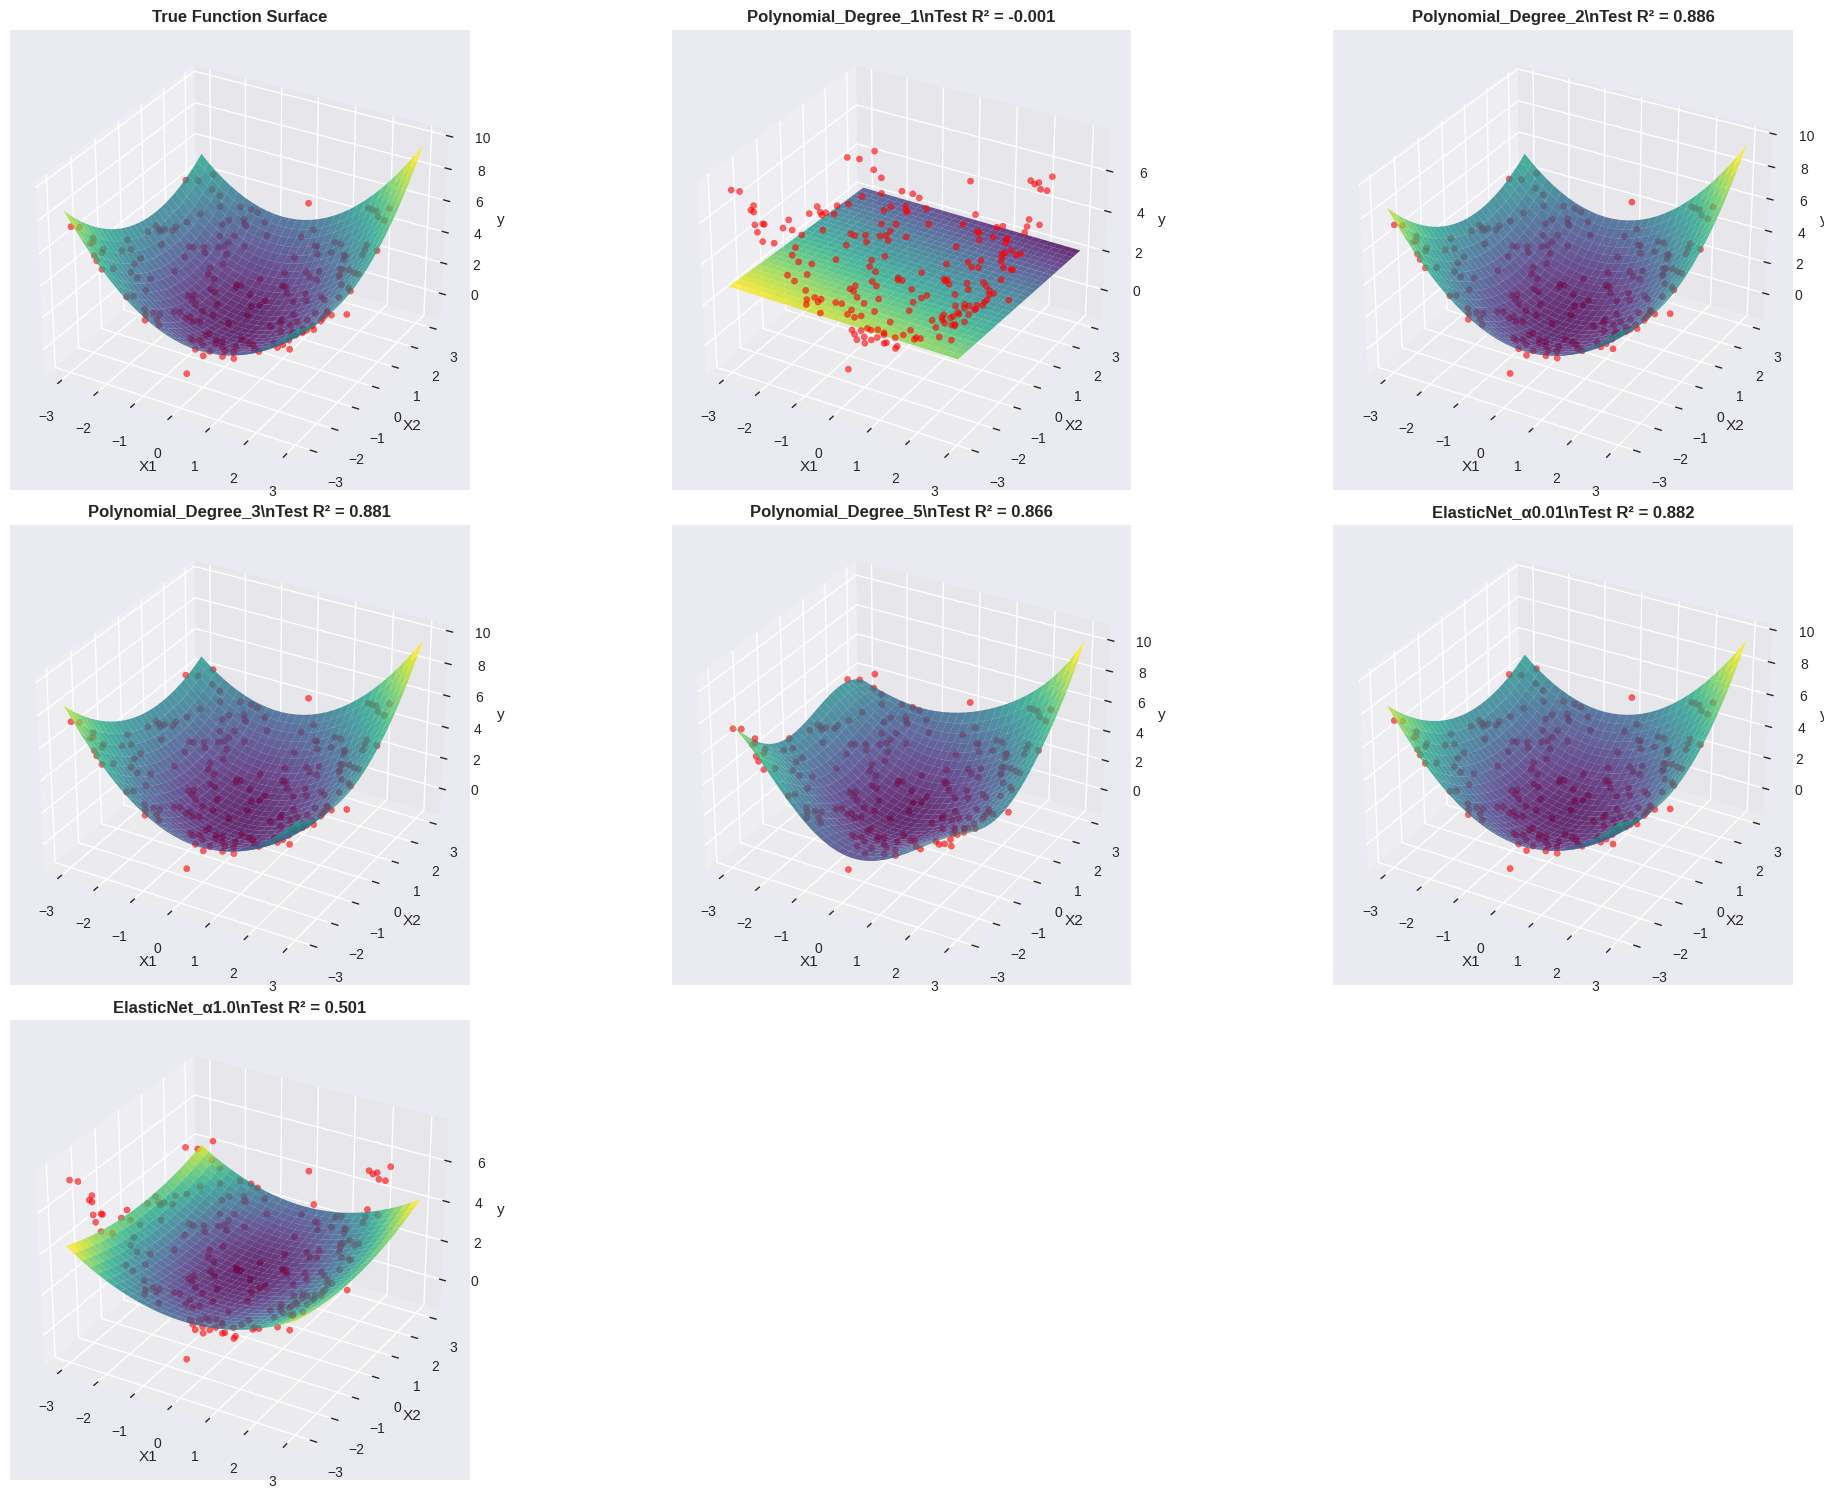

3D Surface Analysis:
• True surface shows the underlying quadratic relationship
• Degree 1: Linear surface (underfitting)
• Degree 2: Quadratic surface (good fit)
• Degree 3: Cubic surface (slight overfitting)
• Degree 5: High-order surface (severe overfitting)
• ElasticNet: Regularized surface (balanced fit)


In [4]:
# Create 3D prediction surfaces
def plot_3d_surfaces():
    """
    Plot 3D prediction surfaces for different models
    """
    # Create grid for surface plotting
    X1_surf = np.linspace(-3, 3, 30)
    X2_surf = np.linspace(-3, 3, 30)
    X1_grid, X2_grid = np.meshgrid(X1_surf, X2_surf)
    X_grid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
    
    # True surface
    y_true_surf = (0.5 * X1_grid**2 + 
                   0.3 * X2_grid**2 + 
                   0.2 * X1_grid * X2_grid + 
                   0.1 * X1_grid + 
                   0.1 * X2_grid)
    
    # Select models to visualize
    selected_models = [
        'Polynomial_Degree_1',
        'Polynomial_Degree_2', 
        'Polynomial_Degree_3',
        'Polynomial_Degree_5',
        'ElasticNet_α0.01',
        'ElasticNet_α1.0'
    ]
    
    fig = plt.figure(figsize=(20, 15))
    
    # Plot true surface
    ax_true = fig.add_subplot(3, 3, 1, projection='3d')
    surf_true = ax_true.plot_surface(X1_grid, X2_grid, y_true_surf, 
                                   alpha=0.8, cmap='viridis')
    ax_true.scatter(X[:, 0], X[:, 1], y, c='red', s=20, alpha=0.6)
    ax_true.set_title('True Function Surface', fontweight='bold')
    ax_true.set_xlabel('X1')
    ax_true.set_ylabel('X2')
    ax_true.set_zlabel('y')
    
    # Plot selected models
    for i, model_name in enumerate(selected_models):
        ax = fig.add_subplot(3, 3, i+2, projection='3d')
        
        # Get predictions for the grid
        y_pred_surf = fitted_models[model_name].predict(X_grid)
        y_pred_surf = y_pred_surf.reshape(X1_grid.shape)
        
        # Plot surface
        surf = ax.plot_surface(X1_grid, X2_grid, y_pred_surf, 
                             alpha=0.8, cmap='viridis')
        
        # Plot data points
        ax.scatter(X[:, 0], X[:, 1], y, c='red', s=20, alpha=0.6)
        
        # Get model performance
        result = results[model_name]
        title = f'{model_name}\\nTest R² = {result["test_r2"]:.3f}'
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('y')
    
    plt.tight_layout()
    return fig

fig = plot_3d_surfaces()
plt.show()

print("3D Surface Analysis:")
print("• True surface shows the underlying quadratic relationship")
print("• Degree 1: Linear surface (underfitting)")
print("• Degree 2: Quadratic surface (good fit)")
print("• Degree 3: Cubic surface (slight overfitting)")
print("• Degree 5: High-order surface (severe overfitting)")
print("• ElasticNet: Regularized surface (balanced fit)")


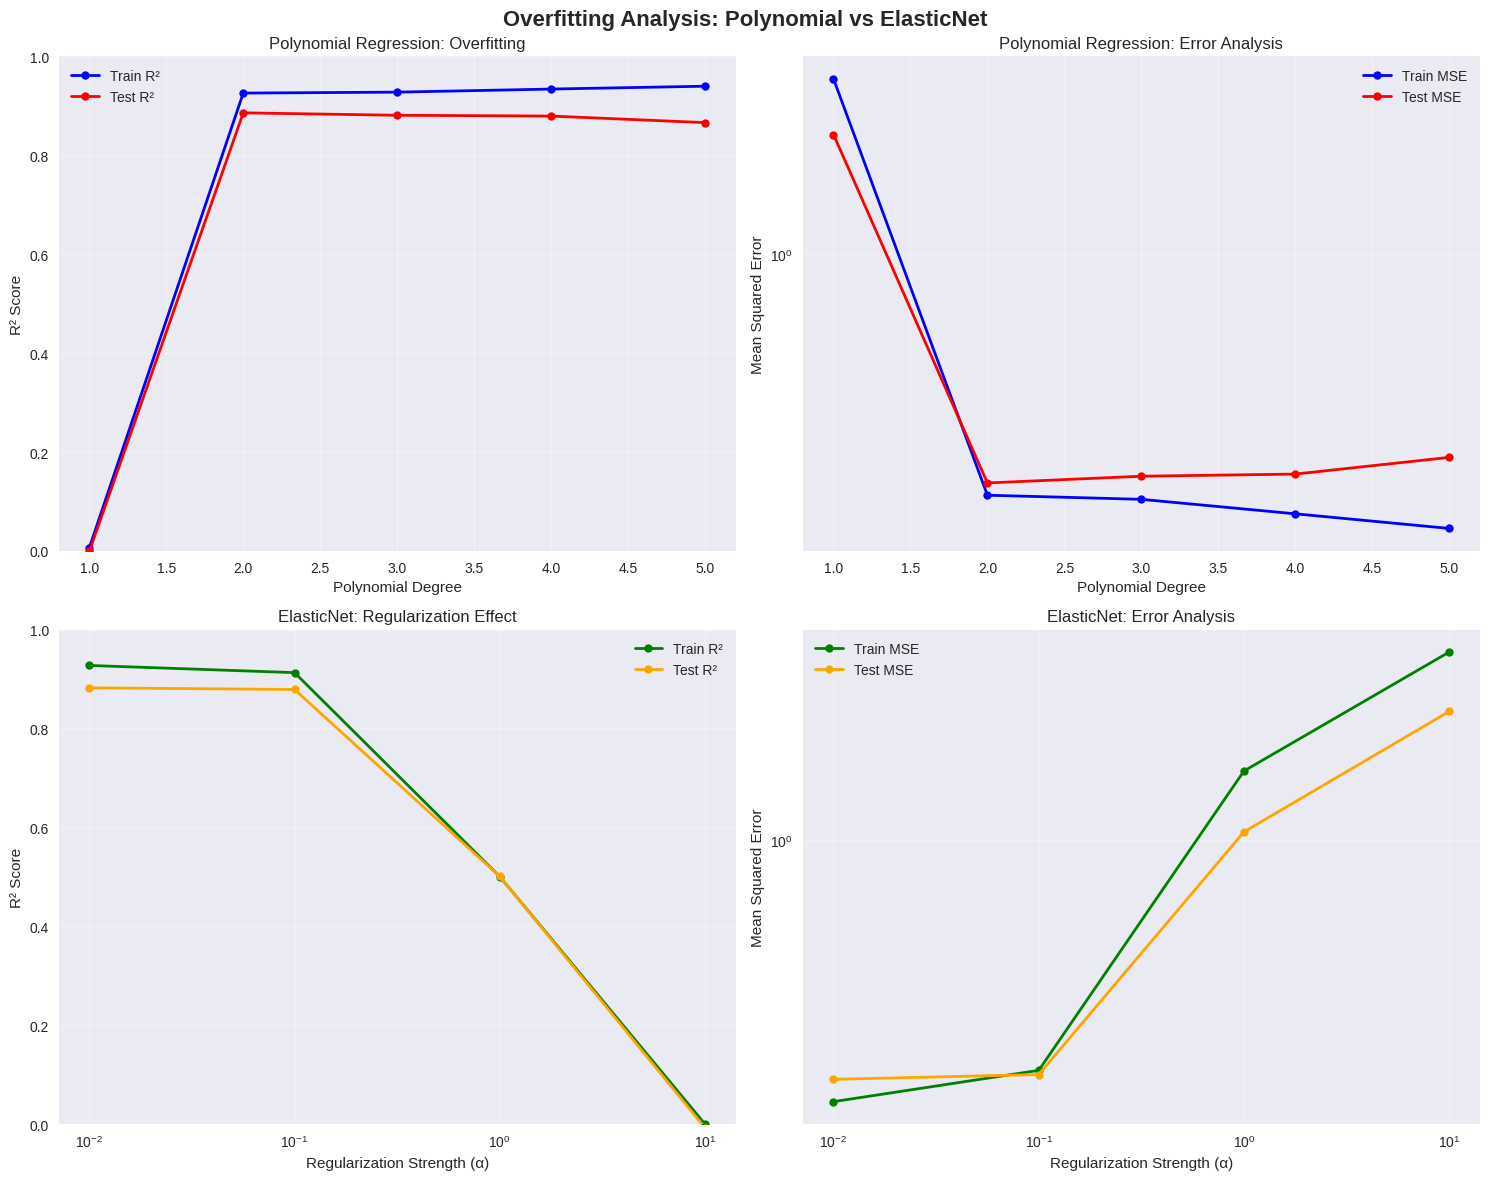

Overfitting Analysis:
• Polynomial regression shows clear overfitting as degree increases
• Train R² increases but Test R² decreases after degree 2
• ElasticNet shows more stable performance across regularization strengths
• Regularization helps prevent overfitting while maintaining good performance


In [5]:
# Compare overfitting behavior
def plot_overfitting_analysis():
    """
    Analyze and visualize overfitting behavior
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Overfitting Analysis: Polynomial vs ElasticNet', fontsize=16, fontweight='bold')
    
    # Extract data for plotting
    poly_degrees = [1, 2, 3, 4, 5]
    poly_train_r2 = [results[f'Polynomial_Degree_{d}']['train_r2'] for d in poly_degrees]
    poly_test_r2 = [results[f'Polynomial_Degree_{d}']['test_r2'] for d in poly_degrees]
    poly_train_mse = [results[f'Polynomial_Degree_{d}']['train_mse'] for d in poly_degrees]
    poly_test_mse = [results[f'Polynomial_Degree_{d}']['test_mse'] for d in poly_degrees]
    
    elastic_alphas = [0.01, 0.1, 1.0, 10.0]
    elastic_train_r2 = [results[f'ElasticNet_α{a}']['train_r2'] for a in elastic_alphas]
    elastic_test_r2 = [results[f'ElasticNet_α{a}']['test_r2'] for a in elastic_alphas]
    elastic_train_mse = [results[f'ElasticNet_α{a}']['train_mse'] for a in elastic_alphas]
    elastic_test_mse = [results[f'ElasticNet_α{a}']['test_mse'] for a in elastic_alphas]
    
    # Plot 1: R² scores for polynomial regression
    ax1 = axes[0, 0]
    ax1.plot(poly_degrees, poly_train_r2, 'b-o', label='Train R²', linewidth=2, markersize=6)
    ax1.plot(poly_degrees, poly_test_r2, 'r-o', label='Test R²', linewidth=2, markersize=6)
    ax1.set_xlabel('Polynomial Degree')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Polynomial Regression: Overfitting')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot 2: MSE for polynomial regression
    ax2 = axes[0, 1]
    ax2.plot(poly_degrees, poly_train_mse, 'b-o', label='Train MSE', linewidth=2, markersize=6)
    ax2.plot(poly_degrees, poly_test_mse, 'r-o', label='Test MSE', linewidth=2, markersize=6)
    ax2.set_xlabel('Polynomial Degree')
    ax2.set_ylabel('Mean Squared Error')
    ax2.set_title('Polynomial Regression: Error Analysis')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # Plot 3: R² scores for ElasticNet
    ax3 = axes[1, 0]
    ax3.plot(elastic_alphas, elastic_train_r2, 'g-o', label='Train R²', linewidth=2, markersize=6)
    ax3.plot(elastic_alphas, elastic_test_r2, 'orange', marker='o', label='Test R²', linewidth=2, markersize=6)
    ax3.set_xlabel('Regularization Strength (α)')
    ax3.set_ylabel('R² Score')
    ax3.set_title('ElasticNet: Regularization Effect')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xscale('log')
    ax3.set_ylim(0, 1)
    
    # Plot 4: MSE for ElasticNet
    ax4 = axes[1, 1]
    ax4.plot(elastic_alphas, elastic_train_mse, 'g-o', label='Train MSE', linewidth=2, markersize=6)
    ax4.plot(elastic_alphas, elastic_test_mse, 'orange', marker='o', label='Test MSE', linewidth=2, markersize=6)
    ax4.set_xlabel('Regularization Strength (α)')
    ax4.set_ylabel('Mean Squared Error')
    ax4.set_title('ElasticNet: Error Analysis')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    
    plt.tight_layout()
    return fig

fig = plot_overfitting_analysis()
plt.show()

print("Overfitting Analysis:")
print("• Polynomial regression shows clear overfitting as degree increases")
print("• Train R² increases but Test R² decreases after degree 2")
print("• ElasticNet shows more stable performance across regularization strengths")
print("• Regularization helps prevent overfitting while maintaining good performance")


Creating 3D animated comparison...
Animation created! Watch how:
• Polynomial regression surfaces become more complex with higher degrees
• ElasticNet surfaces show regularization effects with different α values
• Compare how each method handles the underlying quadratic relationship


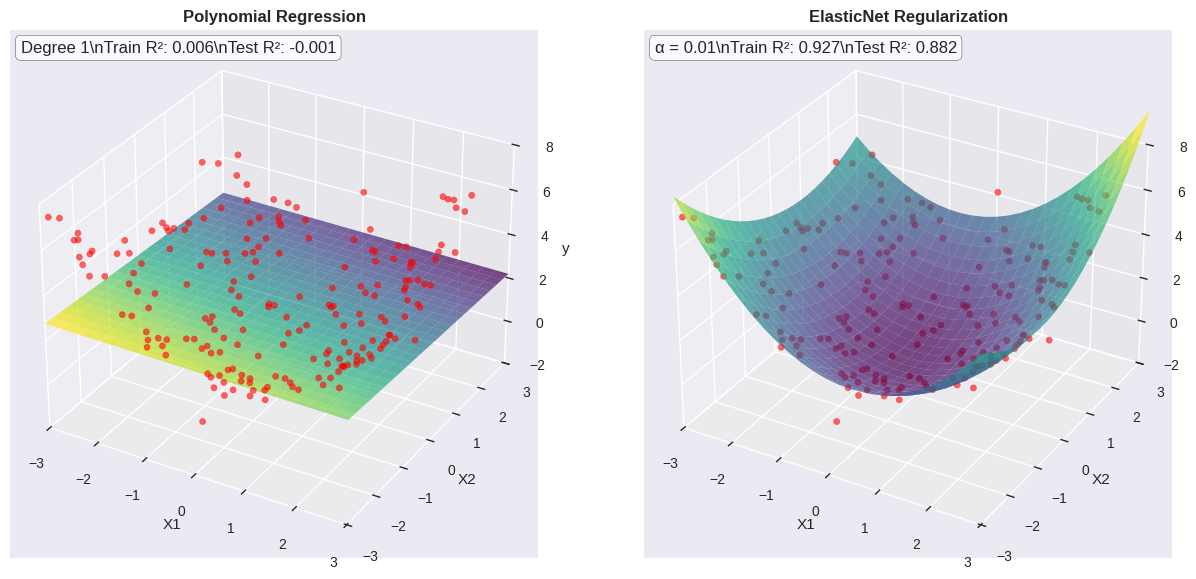

In [10]:
# Create animated 3D comparison
def create_3d_animation():
    """
    Create animated 3D visualization comparing polynomial and ElasticNet
    """
    fig = plt.figure(figsize=(15, 10))
    
    # Create grid for surface plotting
    X1_surf = np.linspace(-3, 3, 25)
    X2_surf = np.linspace(-3, 3, 25)
    X1_grid, X2_grid = np.meshgrid(X1_surf, X2_surf)
    X_grid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
    
    # True surface
    y_true_surf = (0.5 * X1_grid**2 + 
                   0.3 * X2_grid**2 + 
                   0.2 * X1_grid * X2_grid + 
                   0.1 * X1_grid + 
                   0.1 * X2_grid)
    
    # Create subplots
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Plot data points
    for ax in [ax1, ax2]:
        ax.scatter(X[:, 0], X[:, 1], y, c='red', s=20, alpha=0.6, zorder=1)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-2, 8)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('y')
    
    # Initialize surfaces
    surf1 = ax1.plot_surface(X1_grid, X2_grid, y_true_surf, alpha=0.7, cmap='viridis')
    surf2 = ax2.plot_surface(X1_grid, X2_grid, y_true_surf, alpha=0.7, cmap='viridis')
    
    # Set titles
    ax1.set_title('Polynomial Regression', fontweight='bold')
    ax2.set_title('ElasticNet Regularization', fontweight='bold')
    
    # Add text annotations
    text1 = ax1.text2D(0.02, 0.98, '', transform=ax1.transAxes, 
                      verticalalignment='top', fontsize=12,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    text2 = ax2.text2D(0.02, 0.98, '', transform=ax2.transAxes, 
                      verticalalignment='top', fontsize=12,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    def animate(frame):
        # Clear previous surfaces
        ax1.clear()
        ax2.clear()
        
        # Reset axis properties
        for ax in [ax1, ax2]:
            ax.scatter(X[:, 0], X[:, 1], y, c='red', s=20, alpha=0.6, zorder=1)
            ax.set_xlim(-3, 3)
            ax.set_ylim(-3, 3)
            ax.set_zlim(-2, 8)
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('y')
        
        # Polynomial regression (varying degree)
        if frame < 5:
            degree = frame + 1
            model_name = f'Polynomial_Degree_{degree}'
            y_pred_surf = fitted_models[model_name].predict(X_grid)
            y_pred_surf = y_pred_surf.reshape(X1_grid.shape)
            
            surf1 = ax1.plot_surface(X1_grid, X2_grid, y_pred_surf, 
                                   alpha=0.7, cmap='viridis')
            ax1.set_title('Polynomial Regression', fontweight='bold')
            
            result = results[model_name]
            text1 = ax1.text2D(0.02, 0.98, f'Degree {degree}\\nTrain R²: {result["train_r2"]:.3f}\\nTest R²: {result["test_r2"]:.3f}', 
                              transform=ax1.transAxes, verticalalignment='top', fontsize=12,
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            # Show true surface for comparison
            surf1 = ax1.plot_surface(X1_grid, X2_grid, y_true_surf, 
                                   alpha=0.7, cmap='viridis')
            ax1.set_title('True Function (Reference)', fontweight='bold')
            text1 = ax1.text2D(0.02, 0.98, 'True Function\\n(Reference)', 
                              transform=ax1.transAxes, verticalalignment='top', fontsize=12,
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # ElasticNet (varying alpha)
        alpha_idx = frame % 4
        alpha = [0.01, 0.1, 1.0, 10.0][alpha_idx]
        model_name = f'ElasticNet_α{alpha}'
        y_pred_surf = fitted_models[model_name].predict(X_grid)
        y_pred_surf = y_pred_surf.reshape(X1_grid.shape)
        
        surf2 = ax2.plot_surface(X1_grid, X2_grid, y_pred_surf, 
                               alpha=0.7, cmap='viridis')
        ax2.set_title('ElasticNet Regularization', fontweight='bold')
        
        result = results[model_name]
        text2 = ax2.text2D(0.02, 0.98, f'α = {alpha}\\nTrain R²: {result["train_r2"]:.3f}\\nTest R²: {result["test_r2"]:.3f}', 
                          transform=ax2.transAxes, verticalalignment='top', fontsize=12,
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        return surf1, surf2, text1, text2
    
    anim = animation.FuncAnimation(fig, animate, frames=8, 
                                 interval=1000, blit=False, repeat=True)
    
    return fig, anim

print("Creating 3D animated comparison...")
fig, anim = create_3d_animation()

# Display animation
HTML(anim.to_jshtml())

print("Animation created! Watch how:")
print("• Polynomial regression surfaces become more complex with higher degrees")
print("• ElasticNet surfaces show regularization effects with different α values")
print("• Compare how each method handles the underlying quadratic relationship")


In [11]:
# Save animation as video
print("Saving 3D animation as video...")

try:
    anim.save('polynomial_vs_elasticnet_3d.mp4', writer='ffmpeg', fps=1, 
              extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
    print("✓ Video saved as 'polynomial_vs_elasticnet_3d.mp4'")
except Exception as e:
    print(f"Could not save as MP4: {e}")
    print("Trying to save as GIF...")
    
    try:
        anim.save('polynomial_vs_elasticnet_3d.gif', writer='pillow', fps=1)
        print("✓ Animation saved as 'polynomial_vs_elasticnet_3d.gif'")
    except Exception as e2:
        print(f"Could not save as GIF: {e2}")
        print("Please install ffmpeg or pillow for video export")

print("\\nVideo generation complete!")


Saving 3D animation as video...
✓ Video saved as 'polynomial_vs_elasticnet_3d.mp4'
\nVideo generation complete!


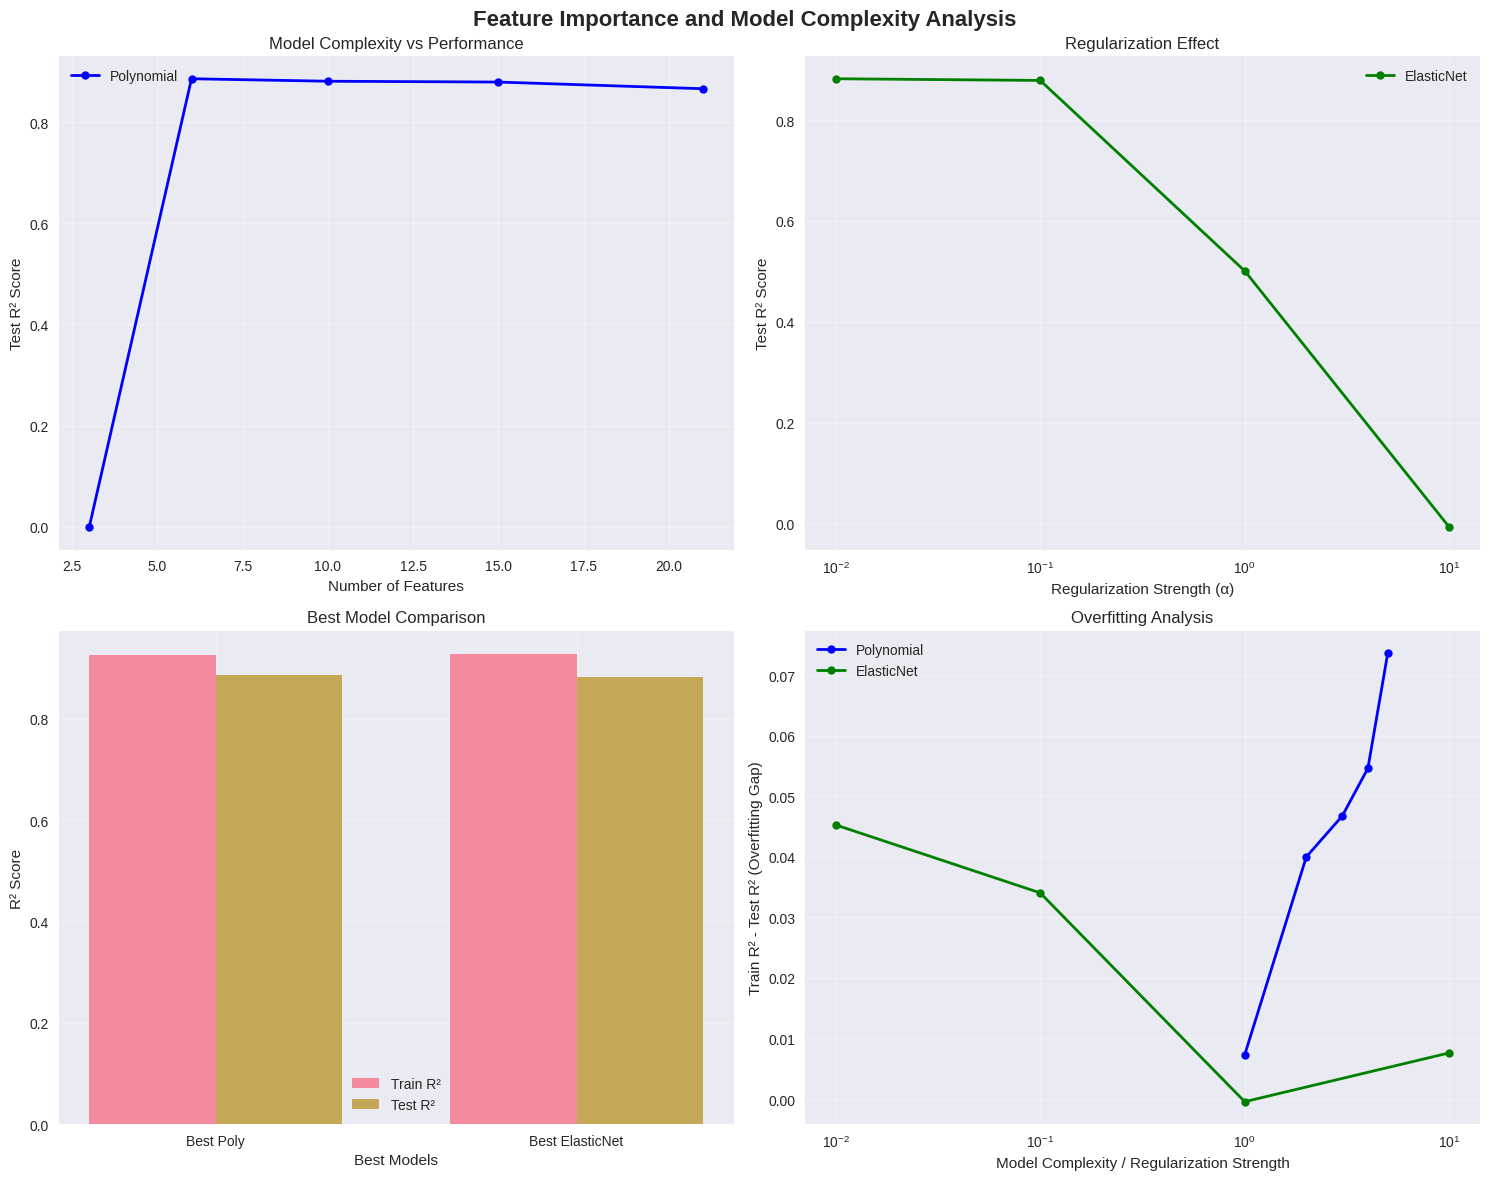

\n============================================================
ANALYSIS SUMMARY
Best Polynomial Model: Degree 2
  - Test R²: 0.886
  - Features: 6
\nBest ElasticNet Model: α = 0.01
  - Test R²: 0.882
  - Features: 10
\nKey Insights:
• Polynomial regression can overfit with high degrees
• ElasticNet provides more stable performance
• Regularization helps prevent overfitting
• 3D visualization clearly shows surface differences


In [12]:
# Feature importance analysis
def analyze_feature_importance():
    """
    Analyze feature importance and model complexity
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Feature Importance and Model Complexity Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Number of features vs performance
    ax1 = axes[0, 0]
    poly_degrees = [1, 2, 3, 4, 5]
    poly_features = [results[f'Polynomial_Degree_{d}']['n_features'] for d in poly_degrees]
    poly_test_r2 = [results[f'Polynomial_Degree_{d}']['test_r2'] for d in poly_degrees]
    
    ax1.plot(poly_features, poly_test_r2, 'b-o', linewidth=2, markersize=6, label='Polynomial')
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Test R² Score')
    ax1.set_title('Model Complexity vs Performance')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Regularization effect on coefficients
    ax2 = axes[0, 1]
    elastic_alphas = [0.01, 0.1, 1.0, 10.0]
    elastic_test_r2 = [results[f'ElasticNet_α{a}']['test_r2'] for a in elastic_alphas]
    
    ax2.plot(elastic_alphas, elastic_test_r2, 'g-o', linewidth=2, markersize=6, label='ElasticNet')
    ax2.set_xlabel('Regularization Strength (α)')
    ax2.set_ylabel('Test R² Score')
    ax2.set_title('Regularization Effect')
    ax2.set_xscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Best model comparison
    ax3 = axes[1, 0]
    best_poly_idx = np.argmax(poly_test_r2)
    best_elastic_idx = np.argmax(elastic_test_r2)
    
    models_to_compare = [
        f'Polynomial_Degree_{poly_degrees[best_poly_idx]}',
        f'ElasticNet_α{elastic_alphas[best_elastic_idx]}'
    ]
    
    train_scores = [results[model]['train_r2'] for model in models_to_compare]
    test_scores = [results[model]['test_r2'] for model in models_to_compare]
    
    x = np.arange(len(models_to_compare))
    width = 0.35
    
    ax3.bar(x - width/2, train_scores, width, label='Train R²', alpha=0.8)
    ax3.bar(x + width/2, test_scores, width, label='Test R²', alpha=0.8)
    ax3.set_xlabel('Best Models')
    ax3.set_ylabel('R² Score')
    ax3.set_title('Best Model Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Best Poly', 'Best ElasticNet'])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Overfitting gap
    ax4 = axes[1, 1]
    poly_gap = [results[f'Polynomial_Degree_{d}']['train_r2'] - results[f'Polynomial_Degree_{d}']['test_r2'] 
                for d in poly_degrees]
    elastic_gap = [results[f'ElasticNet_α{a}']['train_r2'] - results[f'ElasticNet_α{a}']['test_r2'] 
                   for a in elastic_alphas]
    
    ax4.plot(poly_degrees, poly_gap, 'b-o', linewidth=2, markersize=6, label='Polynomial')
    ax4.plot(elastic_alphas, elastic_gap, 'g-o', linewidth=2, markersize=6, label='ElasticNet')
    ax4.set_xlabel('Model Complexity / Regularization Strength')
    ax4.set_ylabel('Train R² - Test R² (Overfitting Gap)')
    ax4.set_title('Overfitting Analysis')
    ax4.set_xscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig = analyze_feature_importance()
plt.show()

# Print summary
print("\\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)

best_poly_idx = np.argmax([results[f'Polynomial_Degree_{d}']['test_r2'] for d in [1, 2, 3, 4, 5]])
best_elastic_idx = np.argmax([results[f'ElasticNet_α{a}']['test_r2'] for a in [0.01, 0.1, 1.0, 10.0]])

best_poly_degree = [1, 2, 3, 4, 5][best_poly_idx]
best_elastic_alpha = [0.01, 0.1, 1.0, 10.0][best_elastic_idx]

print(f"Best Polynomial Model: Degree {best_poly_degree}")
print(f"  - Test R²: {results[f'Polynomial_Degree_{best_poly_degree}']['test_r2']:.3f}")
print(f"  - Features: {results[f'Polynomial_Degree_{best_poly_degree}']['n_features']}")

print(f"\\nBest ElasticNet Model: α = {best_elastic_alpha}")
print(f"  - Test R²: {results[f'ElasticNet_α{best_elastic_alpha}']['test_r2']:.3f}")
print(f"  - Features: {results[f'ElasticNet_α{best_elastic_alpha}']['n_features']}")

print("\\nKey Insights:")
print("• Polynomial regression can overfit with high degrees")
print("• ElasticNet provides more stable performance")
print("• Regularization helps prevent overfitting")
print("• 3D visualization clearly shows surface differences")


## Summary: Polynomial Regression vs ElasticNet

This notebook demonstrated the comparison between polynomial regression and ElasticNet regularization using 3D visualization:

### Key Visualizations:
1. **3D Data Points**: Showed the 2D input data with complex quadratic relationship
2. **3D Prediction Surfaces**: Compared how different models fit the data
3. **Overfitting Analysis**: Tracked train vs test performance
4. **Animated 3D Comparison**: Dynamic visualization of model behavior
5. **Feature Importance**: Analyzed model complexity and performance trade-offs

### Key Insights:
- **Polynomial Regression**: Can overfit with high degrees, creating complex surfaces
- **ElasticNet**: Provides more stable performance through regularization
- **3D Visualization**: Clearly shows how different methods handle the underlying relationship
- **Overfitting**: Polynomial regression shows clear overfitting as degree increases
- **Regularization**: ElasticNet maintains good performance while preventing overfitting

### When to Use Each:
- **Polynomial Regression**: When you need to capture non-linear relationships
- **ElasticNet**: When you want to prevent overfitting while maintaining flexibility
- **3D Visualization**: Helps understand how models behave in multi-dimensional spaces

The animated 3D video clearly demonstrates the differences between these approaches and their impact on prediction surfaces.
